In [1]:
import torch
print(torch.__version__)

2.3.1


# Eval for different Sigma Soft

In [ ]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

=== sigma_soft = 2 ===
   Repeat 1/8, final price=5.3059
   Repeat 2/8, final price=5.3229
   Repeat 3/8, final price=5.3111
   Repeat 4/8, final price=5.3102
   Repeat 5/8, final price=5.3193
   Repeat 6/8, final price=5.3213
   Repeat 7/8, final price=5.3123
   Repeat 8/8, final price=5.3196
=== sigma_soft = 1.5 ===
   Repeat 1/8, final price=5.3133
   Repeat 2/8, final price=5.3230
   Repeat 3/8, final price=5.3166
   Repeat 4/8, final price=5.3202
   Repeat 5/8, final price=5.3178
   Repeat 6/8, final price=5.3179
   Repeat 7/8, final price=5.3164
   Repeat 8/8, final price=5.3220
=== sigma_soft = 1 ===
   Repeat 1/8, final price=5.3198
   Repeat 2/8, final price=5.3176
   Repeat 3/8, final price=5.3191
   Repeat 4/8, final price=5.3210
   Repeat 5/8, final price=5.3173
   Repeat 6/8, final price=5.3210
   Repeat 7/8, final price=5.3201
   Repeat 8/8, final price=5.3179
=== sigma_soft = 0.5 ===
   Repeat 1/8, final price=5.3223
   Repeat 2/8, final price=5.2933
   Repeat 3/8, final

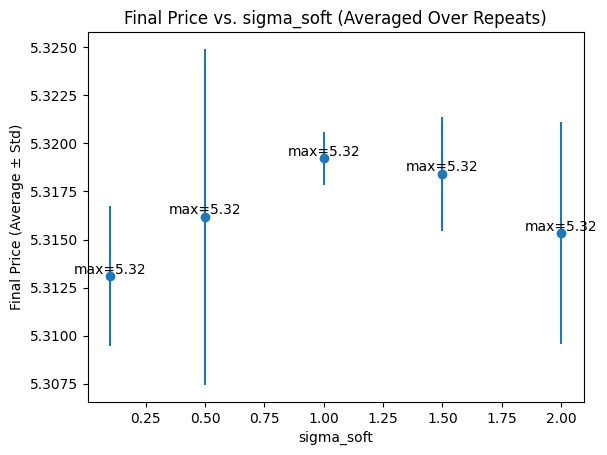

In [92]:
S0 = 40.0       
K = 40.0        
r = 0.06       
sigma = 0.4   
T = 1.0         

num_steps = 50
dt = T / num_steps

device = torch.device("cpu")  


def simulate_paths(S0, r, vol, T, num_steps, num_paths, seed=None):
    """
    Simulate GBM paths under risk-neutral measure.
    """
    if seed is not None:
        np.random.seed(seed)
    dt_local = T / num_steps
    
    S = np.zeros((num_paths, num_steps + 1), dtype=np.float32)
    S[:, 0] = S0
    for t in range(num_steps):
        z = np.random.normal(0.0, 1.0, size=num_paths).astype(np.float32)
        S[:, t+1] = S[:, t] * np.exp((r - 0.5 * vol**2) * dt_local + vol * np.sqrt(dt_local) * z)
    return S


class ContinuationValueNet(nn.Module):
    def __init__(self, hidden_size=32):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        
        self.activation = nn.ReLU()

    def forward(self, t_normalized, logS):
        # Ensure shapes
        if t_normalized.dim() == 1:
            t_normalized = t_normalized.unsqueeze(1)
        if logS.dim() == 1:
            logS = logS.unsqueeze(1)
        x = torch.cat([t_normalized, logS], dim=1)
        
        h = self.activation(self.fc1(x))
        h = self.activation(self.fc2(h))
        out = self.fc3(h)
        return out.squeeze(1)


def evaluate_sharp_policy(net, num_paths, seed_eval=9999):
    net.eval()
    
    with torch.no_grad():
        S_data = simulate_paths(S0, r, sigma, T, num_steps, num_paths, seed=seed_eval)
        payoffs = np.zeros(num_paths, dtype=np.float32)
        
        for i in range(num_paths):
            path = S_data[i]
            exercised = False
            payoff_val = 0.0
            for t in range(num_steps+1):
                if t == num_steps:
                    # forced exercise at maturity
                    payoff_val = np.exp(-r * T) * max(K - path[t], 0)
                    break
                else:
                    payoff_now = max(K - path[t], 0)
                    disc_payoff_now = np.exp(-r * (t*dt)) * payoff_now
                    
                    logS_t = np.log(path[t] + 1e-12)
                    t_norm = float(t) / num_steps
                    
                    cont_val = net(
                        torch.tensor([t_norm], dtype=torch.float32, device=device),
                        torch.tensor([logS_t], dtype=torch.float32, device=device)
                    ).item()
                    
                    if disc_payoff_now > cont_val:
                        payoff_val = disc_payoff_now
                        exercised = True
                        break
            payoffs[i] = payoff_val
        
        return float(np.mean(payoffs))

def train_and_evaluate_for_sigma(soft_sigma, 
                                 num_epochs=50,
                                 num_train_paths=10000,
                                 num_eval_paths=30000,
                                 batch_size=2000,
                                 seed=None):
    if seed is not None:
        np.random.seed(seed)
        torch.manual_seed(seed)
    
    net = ContinuationValueNet(hidden_size=32).to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    
    steps_per_epoch = num_train_paths // batch_size
    
    for epoch in range(num_epochs):
        S_data = simulate_paths(S0, r, sigma, T, num_steps, num_train_paths)
        idx_perm = np.random.permutation(num_train_paths)
        
        for step_i in range(steps_per_epoch):
            idx_batch = idx_perm[step_i*batch_size : (step_i+1)*batch_size]
            S_batch = S_data[idx_batch]
            
            S_torch = torch.from_numpy(S_batch).float().to(device)
            B = S_torch.shape[0]
            
            survival = torch.ones(B, device=device)
            total_payoffs = torch.zeros(B, device=device)
            
            optimizer.zero_grad()
            
            for t in range(num_steps):
                t_norm = float(t) / num_steps
                discount = np.exp(-r * (t*dt))
                
                payoff_now = torch.clamp(K - S_torch[:, t], min=0.0)
                payoff_disc = discount * payoff_now
                
                logS_torch = torch.log(S_torch[:, t] + 1e-12)
                cont_val = net(
                    torch.full((B,), t_norm, dtype=torch.float32, device=device),
                    logS_torch
                )
                
                x = (payoff_disc - cont_val) / soft_sigma
                p_t = Normal(0.0, 1.0).cdf(x)
                
                instant_reward = survival * p_t * payoff_disc
                total_payoffs += instant_reward
                
                survival = survival * (1.0 - p_t)
            
            payoff_end = torch.clamp(K - S_torch[:, num_steps], min=0.0)
            payoff_end_disc = np.exp(-r * T) * payoff_end
            total_payoffs += survival * payoff_end_disc
            
            loss = -total_payoffs.mean()  # maximize payoff
            loss.backward()
            optimizer.step()
    
    final_price = evaluate_sharp_policy(net, num_eval_paths)
    return final_price, net


def run_multi_experiments(sigma_values,
                          num_repeats=10,
                          num_epochs=50,
                          num_train_paths=20000,
                          num_eval_paths=50000,
                          batch_size=2000):
    all_results = {}
    for sigma_soft in sigma_values:
        print(f"=== sigma_soft = {sigma_soft} ===")
        final_prices = []
        for repeat_idx in range(num_repeats):
            seed_val = 1234 + repeat_idx
            price, net = train_and_evaluate_for_sigma(
                soft_sigma=sigma_soft,
                num_epochs=num_epochs,
                num_train_paths=num_train_paths,
                num_eval_paths=num_eval_paths,
                batch_size=batch_size,
                seed=seed_val
            )
            final_prices.append(price)
            print(f"   Repeat {repeat_idx+1}/{num_repeats}, final price={price:.4f}")
        all_results[sigma_soft] = final_prices
    return all_results

def summarize_results(all_results):
    summary = {}
    print("\nSummary of final prices over multiple runs:\n")
    print("sigma_soft | avg_price  | std_dev    | max_price")
    print("-----------------------------------------------")
    for sigma_soft, price_list in all_results.items():
        arr = np.array(price_list)
        avg_price = arr.mean()
        std_price = arr.std()
        max_price = arr.max()
        summary[sigma_soft] = (avg_price, std_price, max_price)
        print(f"{sigma_soft:9.3f} | {avg_price:10.4f} | {std_price:10.4f} | {max_price:9.4f}")
    return summary

def plot_results(summary):
    sigma_list = sorted(summary.keys())
    avg_prices = [summary[s][0] for s in sigma_list]
    std_devs   = [summary[s][1] for s in sigma_list]
    max_prices = [summary[s][2] for s in sigma_list]
    
    plt.figure()
    plt.errorbar(sigma_list, avg_prices, yerr=std_devs, fmt='o')
    plt.xlabel("sigma_soft")
    plt.ylabel("Final Price (Average ± Std)")
    plt.title("Final Price vs. sigma_soft (Averaged Over Repeats)")
    
    for i, sigma_val in enumerate(sigma_list):
        plt.text(sigma_val, avg_prices[i], f"max={max_prices[i]:.2f}",
                 ha='center', va='bottom')
    
    plt.show()

# Range of sigma_soft to test
sigma_values = [2, 1.5, 1, 0.5, 0.1]

all_results = run_multi_experiments(
    sigma_values=sigma_values,
    num_repeats=8,
    num_epochs=300,
    num_train_paths=20000,
    num_eval_paths=100000,
    batch_size=500
)
summary_stats = summarize_results(all_results)

plot_results(summary_stats)

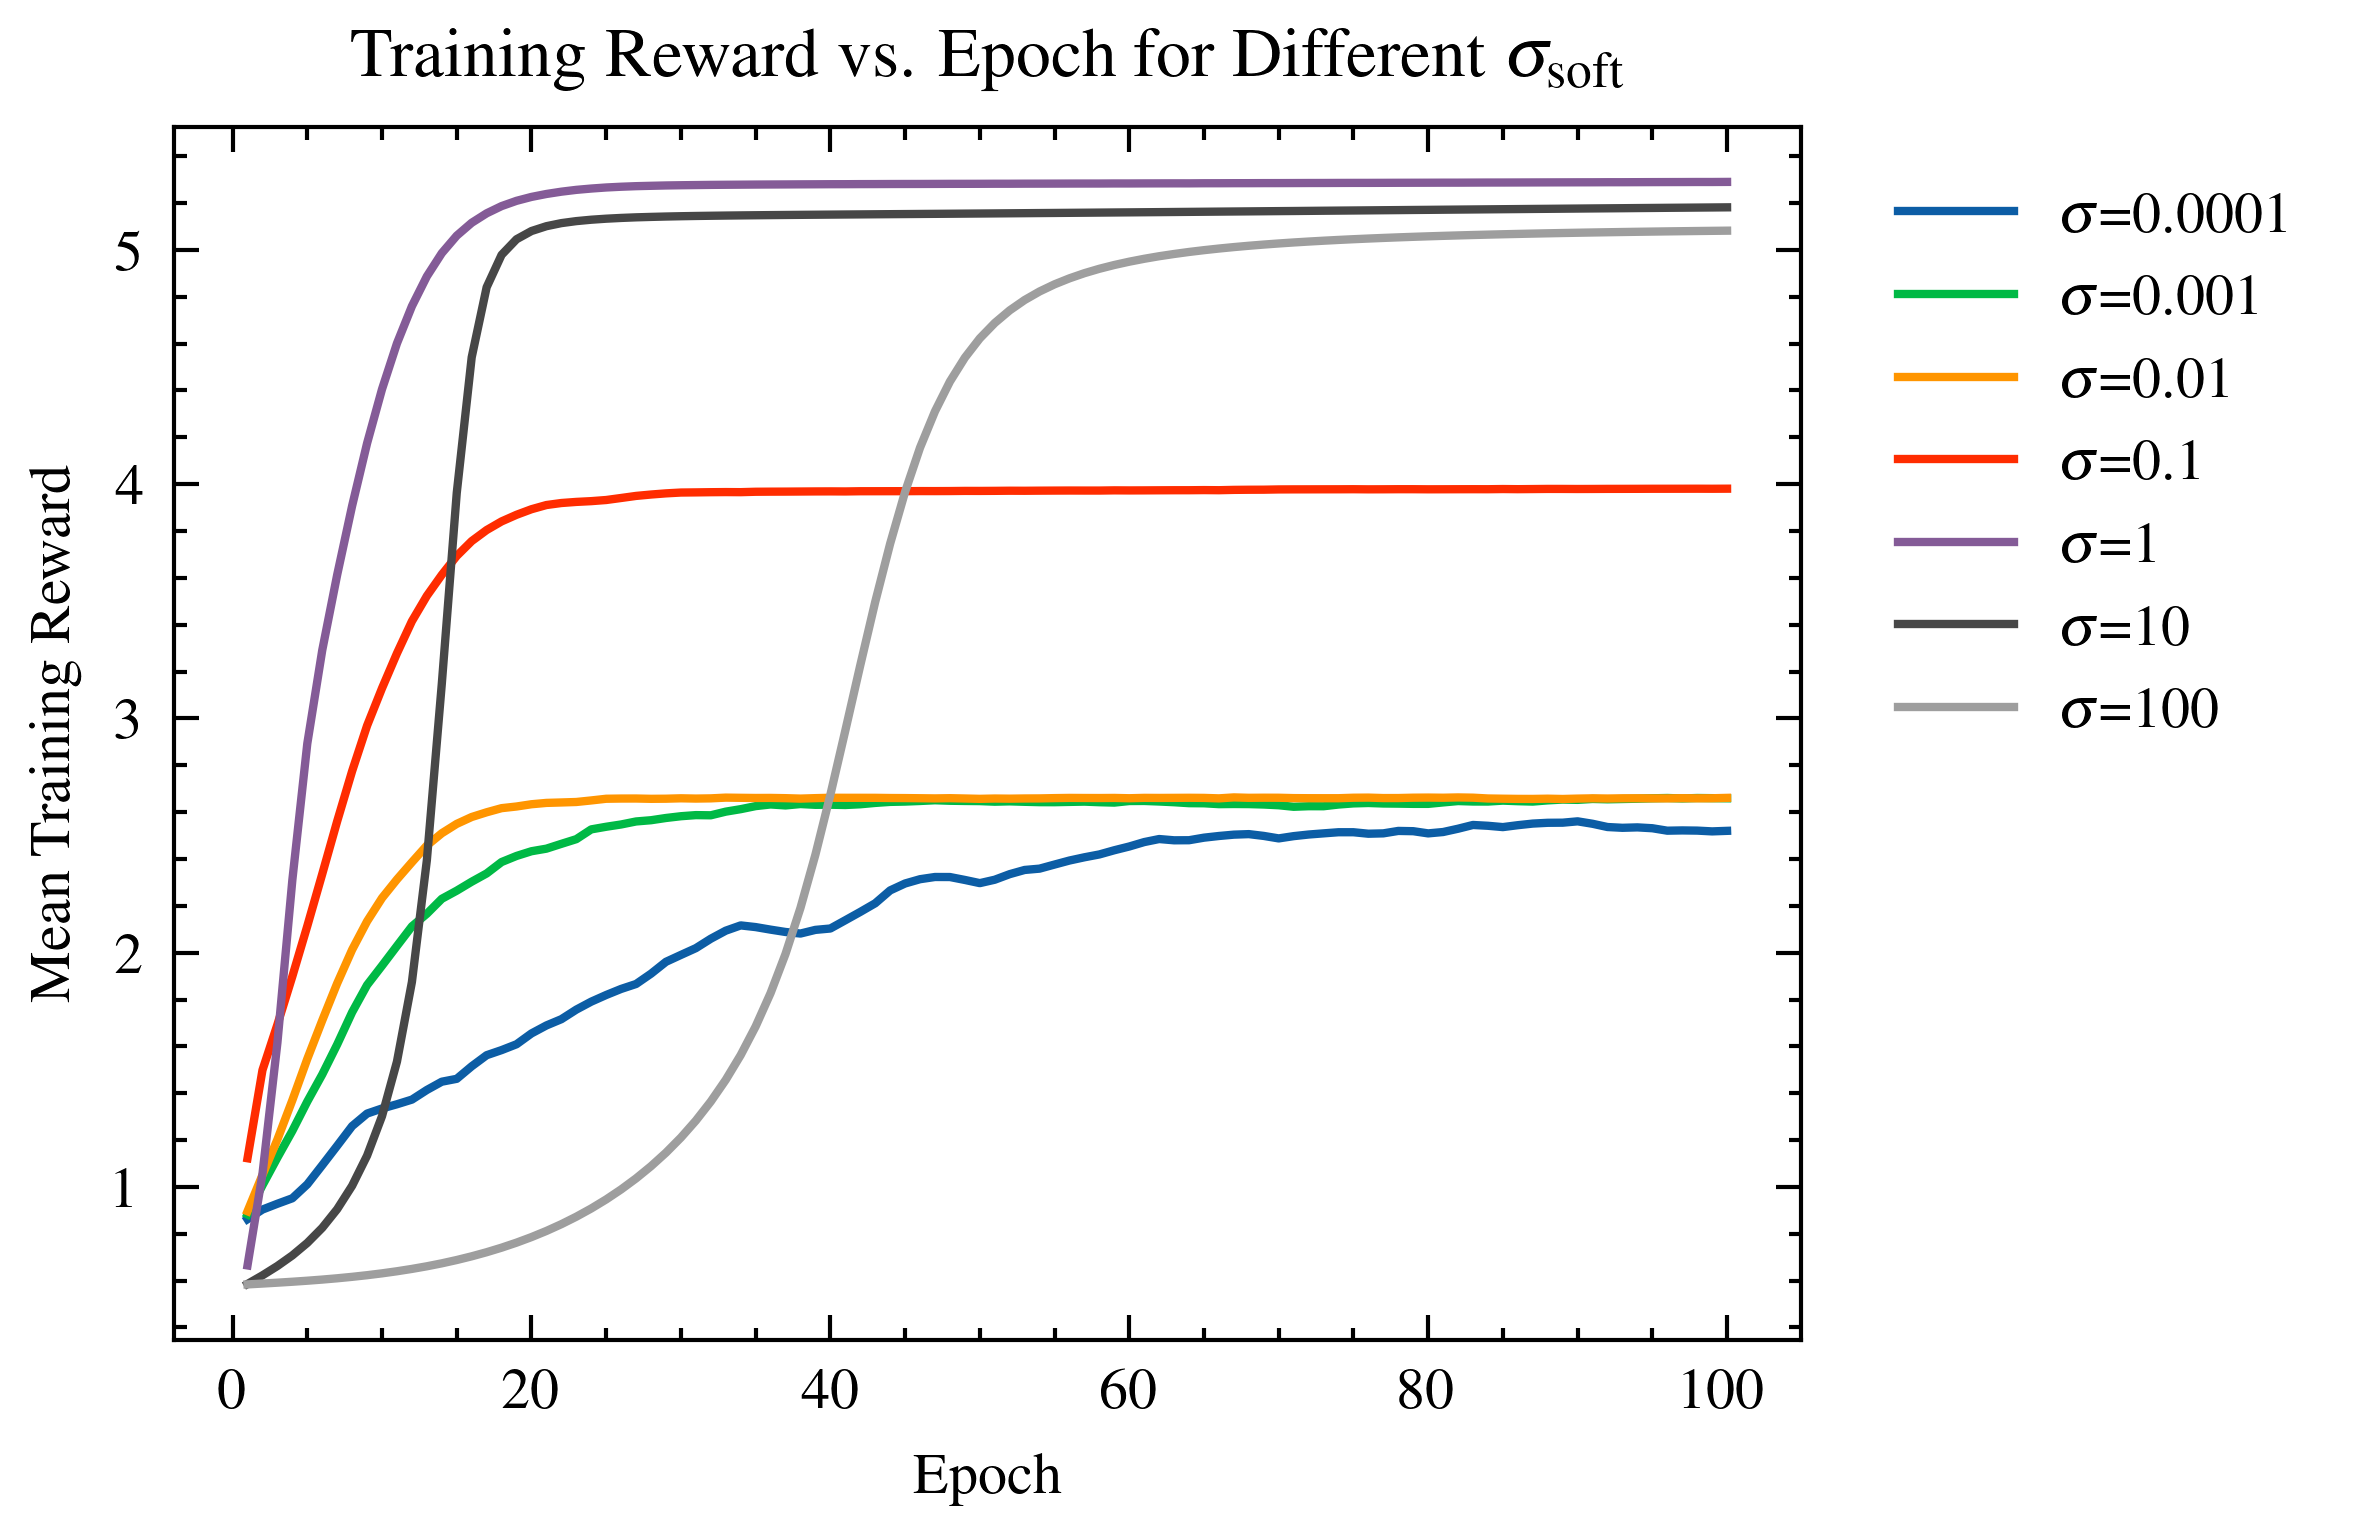

In [35]:
import matplotlib.pyplot as plt
import scienceplots

def plot_training_convergence(all_results, num_epochs):
    plt.figure()
    for sigma_soft, data in all_results.items():
        epoch_curves_list = data['epoch_curves']
        arr = np.array(epoch_curves_list)  # (num_repeats, num_epochs)
        mean_curve = arr.mean(axis=0)
        plt.plot(range(1, num_epochs+1), mean_curve, label=f"$\sigma$={sigma_soft}")
    
    plt.xlabel("Epoch")
    plt.ylabel("Mean Training Reward")
    plt.title(r"Training Reward vs. Epoch for Different $\sigma_{\mathrm{soft}}$")
    plt.legend(frameon=False, fancybox=True, framealpha=0.9,
               loc="upper left", bbox_to_anchor=(1.02, 1.0), borderpad=0.6)

    plt.savefig("training_convergence.pdf", format="pdf", bbox_inches="tight")
    plt.show()


plt.style.use(['science'])
sigma_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
all_results = run_multi_experiments(
    sigma_values=sigma_values,
    num_repeats=4,
    num_epochs=100,        
    num_train_paths=20000, 
    num_eval_paths=30000,
    batch_size=1000      
)
summary_stats = summarize_results(all_results)

plot_training_convergence(all_results, num_epochs=100)